In [1]:
%matplotlib inline
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

### Functions

In [3]:
def get_diff_coeff_library(filename='../03-source/diffusion_coefficient'):
    """Return dataframe with diffusion coefficients from the experimental data
    """
    df = pd.read_pickle(filename)
    df['temperature'] = df['temperature'].replace(243, 240)
    df['transmission'] = df['transmission'].str.replace('%', '')
    df['transmission'] = df['transmission'].str.replace('nan', '100')
    df['transmission'] = df['transmission'].str.replace('~', '')
    df['transmission'] = df['transmission'].astype(float)
    
    return df

# Plots

In [29]:
# df = pd.read_pickle('../03-source/diffusion_coefficient')
# df

In [30]:
# # condition = df[(df['transmission']=='100%') | (df['transmission']=='nan%')]
# # condition2 = df[ df['transmission'].str.contains('22.5', na=False)]
# condition3 = df[ df['transmission'].str.contains('%', na=False)]
# condition3

In [31]:
# df['transmission'] = df['transmission'].str.replace('%', '')
# df['transmission'] = df['transmission'].str.replace('nan', '100')
# df['transmission'] = df['transmission'].str.replace('~', '')
# df


In [32]:
# df['transmission'] = df['transmission'].astype(float)
# df

In [4]:
df2 = get_diff_coeff_library()
df2

,temperature,transmission,D,dD,c
0,240,45.00,0.044803,0.000973,c1
1,240,100.00,0.058330,0.002202,c1
2,220,100.00,0.005152,0.000091,c1
3,220,45.00,0.004381,0.000073,c1
4,220,22.50,0.004355,0.000077,c1
5,240,100.00,0.004758,0.000055,c3
6,240,45.00,0.003454,0.000134,c3
7,240,22.50,0.003750,0.000246,c3
8,240,11.25,0.002887,0.000091,c3
9,250,100.00,0.140541,0.003009,c1


In [5]:
df2 = df2.sort_values(by='transmission', ascending=False)
df2 = df2.sort_values(by='c')
df2

,temperature,transmission,D,dD,c
10,240,100.00,0.058330,0.002202,c1
11,230,100.00,0.018305,0.000290,c1
0,240,45.00,0.044803,0.000973,c1
3,220,45.00,0.004381,0.000073,c1
2,220,100.00,0.005152,0.000091,c1
9,250,100.00,0.140541,0.003009,c1
1,240,100.00,0.058330,0.002202,c1
4,220,22.50,0.004355,0.000077,c1
13,210,100.00,0.002091,0.000042,c1
12,220,100.00,0.006419,0.000093,c1


In [6]:
df2[df2['c']=='c2']

,temperature,transmission,D,dD,c
20,260,100.0,0.121895,0.002851,c2
18,250,100.0,0.047516,0.003283,c2
19,240,100.0,0.015848,0.000249,c2


In [38]:
# df2 = get_diff_coeff_library()

In [7]:
Ts = df2.sort_values(by='temperature')['temperature'].unique()
Ts

array([210, 220, 230, 240, 250, 260])

In [8]:
eta50 = eta_50v_gly()
eta60 = eta_60v_gly()

In [9]:
SE = pd.DataFrame(columns=['temperature', 'D_50', 'D_60'])

for T in Ts:
    row = {'temperature': T, 'D_50': D_coeff(T=T, eta=eta50[T]), "D_60": D_coeff(T=T, eta=eta60[T])}
    SE = SE.append(row, ignore_index=True)
SE

/tmp/ipykernel_23912/3684308659.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE = SE.append(row, ignore_index=True)
/tmp/ipykernel_23912/3684308659.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE = SE.append(row, ignore_index=True)
/tmp/ipykernel_23912/3684308659.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE = SE.append(row, ignore_index=True)
/tmp/ipykernel_23912/3684308659.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SE = SE.append(row, ignore_index=True)
/tmp/ipykernel_23912/3684308659.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pand

,temperature,D_50,D_60
0,210.0,0.000236,0.000035
1,220.0,0.003136,0.000610
2,230.0,0.019798,0.004816
3,240.0,0.078990,0.023163
4,250.0,0.232484,0.079595
5,260.0,0.553158,0.215331


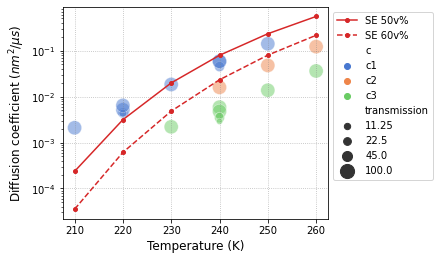

In [10]:
fig, ax = plt.subplots(1,1, figsize=(6,3.5), constrained_layout=True)
ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
ax.plot(SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
sns.scatterplot(data=df2, x='temperature', y='D', hue='c', alpha=.5, size='transmission',sizes=(40, 200), palette="muted", ax=ax)
# sns.lineplot(data=SE, x='temperature', y='D_50', palette='spring', markers=True, ax=ax)

# sns.lineplot(data=SE, x='temperature', y='D_60', markers=True, ax=ax)
# plt.legend(labels=['a', 'b', 'c'])
# sns.lineplot(data=pd.melt(SE, ['temperature']), x='temperature', y='value', palette='pink')
ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('Temperature (K)', fontsize=12)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)

**Arrhenius plot**

In [21]:
D_c1 = df2[(df2['c']=='c1') & (df2['transmission']==100)].sort_values(by='temperature')
D_c2 = df2[(df2['c']=='c2') & (df2['transmission']==100)].sort_values(by='temperature')
D_c3 = df2[(df2['c']=='c3') & (df2['transmission']==100)].sort_values(by='temperature')
D_c2

,temperature,transmission,D,dD,c
19,240,100.0,0.015848,0.000249,c2
18,250,100.0,0.047516,0.003283,c2
20,260,100.0,0.121895,0.002851,c2


In [ ]:
new_tick_locations = np.array([.2, .5, .9])

def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))

In [36]:
SE['temperature'].values

array([210., 220., 230., 240., 250., 260.])

Text(0.5, 0, 'T (K)')

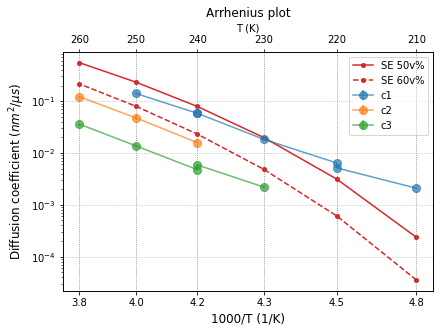

In [49]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5), constrained_layout=True)

ax2 = ax.twiny()

scale = 1e3
ax.plot(scale/SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
ax.plot(scale/SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')

ax.errorbar(scale/D_c1['temperature'], D_c1['D'], D_c1['dD'], label='c1', c='C0', marker='o', ms=8, alpha=.7)
ax.errorbar(scale/D_c2['temperature'], D_c2['D'], D_c2['dD'], label='c2', c='C1', marker='o', ms=8, alpha=.7)
ax.errorbar(scale/D_c3['temperature'], D_c3['D'], D_c3['dD'], label='c3', c='C2', marker='o', ms=8, alpha=.7)

ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel(f'{scale:.0f}/T (1/K)', fontsize=12)
ax.set_xticks(scale/SE['temperature'].values)
ax.set_xticklabels(['%.1f' %x for x in scale/SE['temperature'].values])
ax.set_yscale('log')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)
ax.set_title('Arrhenius plot')

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/SE['temperature'].values)
ax2.set_xticklabels(["%.0f" %x for x in SE['temperature'].values])
ax2.set_xlabel('T (K)')

**Normalize curves**

In [61]:
norm = D_c1.loc[D_c1['temperature'] == 250]['D'].values[0]
D_c1['D'] / norm

13    0.014877
2     0.036656
12    0.045674
11    0.130247
10    0.415041
1     0.415041
9     1.000000
Name: D, dtype: float64

Text(0.5, 0, 'T (K)')

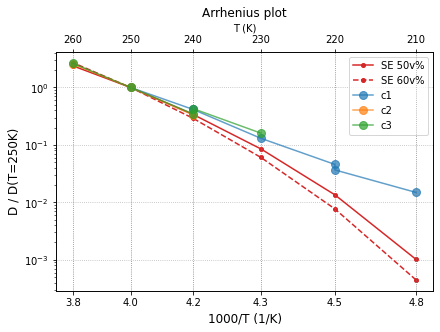

In [65]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5), constrained_layout=True)

ax2 = ax.twiny()

scale, T_norm = 1e3, 250

ax.plot(scale/SE['temperature'], SE['D_50'] / SE.loc[SE['temperature'] == T_norm]['D_50'].values[0] , label='SE 50v%', c='C3', marker='o', ms=4)
ax.plot(scale/SE['temperature'], SE['D_60'] / SE.loc[SE['temperature'] == T_norm]['D_60'].values[0], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')

ax.plot(scale/D_c1['temperature'], D_c1['D']/D_c1.loc[D_c1['temperature'] == T_norm]['D'].values[0], label='c1', c='C0', marker='o', ms=8, alpha=.7)
ax.plot(scale/D_c2['temperature'], D_c2['D']/D_c2.loc[D_c2['temperature'] == T_norm]['D'].values[0], label='c2', c='C1', marker='o', ms=8, alpha=.7)
ax.plot(scale/D_c3['temperature'], D_c3['D']/D_c3.loc[D_c3['temperature'] == T_norm]['D'].values[0], label='c3', c='C2', marker='o', ms=8, alpha=.7)

ax.set_ylabel('D / D(T=250K)', fontsize=12)
ax.set_xlabel(f'{scale:.0f}/T (1/K)', fontsize=12)
ax.set_xticks(scale/SE['temperature'].values)
ax.set_xticklabels(['%.1f' %x for x in scale/SE['temperature'].values])
ax.set_yscale('log')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)
ax.set_title('Arrhenius plot')

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/SE['temperature'].values)
ax2.set_xticklabels(["%.0f" %x for x in SE['temperature'].values])
ax2.set_xlabel('T (K)')

## D vs concentration

### Selected temperature

In [49]:
T_sel = 240

df2[df2['temperature']==T_sel].sort_values(by='c')

,temperature,transmission,D,dD,c
10,240,100.00,0.058330,0.002202,c1
0,240,45.00,0.044803,0.000973,c1
1,240,100.00,0.058330,0.002202,c1
19,240,100.00,0.015848,0.000249,c2
16,240,100.00,0.005881,0.000173,c3
5,240,100.00,0.004758,0.000055,c3
6,240,45.00,0.003454,0.000134,c3
7,240,22.50,0.003750,0.000246,c3
8,240,11.25,0.002887,0.000091,c3


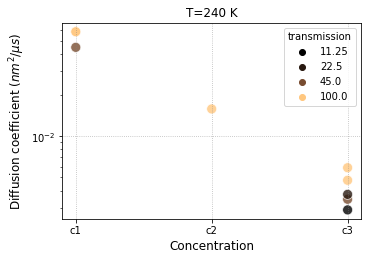

In [50]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5), constrained_layout=True)
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
data = df2[df2['temperature']==T_sel].sort_values(by='c')

sns.scatterplot(data=data, x='c', y='D', hue='transmission', s=100,alpha=.8, ax=ax, palette="copper")
# D_concentrations = df2.sort_values(by='c')

# sns.lineplot(data=SE, x='temperature', y='D_50', palette='spring', markers=True, ax=ax)
# sns.lineplot(data=SE, x='temperature', y='D_60', markers=True, ax=ax)
# plt.legend(labels=['a', 'b', 'c'])
# sns.lineplot(data=pd.melt(SE, ['temperature']), x='temperature', y='value', palette='pink')
ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('Concentration', fontsize=12)
ax.set_yscale('log')
ax.set_title(f'T={T_sel} K')
# ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)

### Selected transmission

In [52]:
Tr_sel = 100
df2[df2['transmission']==Tr_sel].sort_values(by='c')

,temperature,transmission,D,dD,c
10,240,100.0,0.058330,0.002202,c1
11,230,100.0,0.018305,0.000290,c1
2,220,100.0,0.005152,0.000091,c1
9,250,100.0,0.140541,0.003009,c1
1,240,100.0,0.058330,0.002202,c1
13,210,100.0,0.002091,0.000042,c1
12,220,100.0,0.006419,0.000093,c1
20,260,100.0,0.121895,0.002851,c2
18,250,100.0,0.047516,0.003283,c2
19,240,100.0,0.015848,0.000249,c2


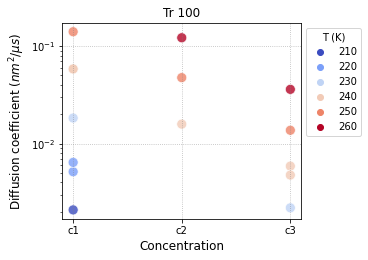

In [58]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5), constrained_layout=True)
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
data = df2[df2['transmission']==Tr_sel].sort_values(by='c')

sns.scatterplot(data=data, x='c', y='D', hue='temperature', s=100,alpha=.8, ax=ax, palette="coolwarm")

ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('Concentration', fontsize=12)
ax.set_yscale('log')
ax.set_title(f'Tr {Tr_sel}%')
ax.legend(bbox_to_anchor=[1,1], title='T (K)')
ax.grid(ls=':', c='gray', alpha=.6)

## D vs Transmission

In [59]:
T_sel = 240
df2[df2['temperature']==T_sel].sort_values(by='c')

,temperature,transmission,D,dD,c
10,240,100.00,0.058330,0.002202,c1
0,240,45.00,0.044803,0.000973,c1
1,240,100.00,0.058330,0.002202,c1
19,240,100.00,0.015848,0.000249,c2
16,240,100.00,0.005881,0.000173,c3
5,240,100.00,0.004758,0.000055,c3
6,240,45.00,0.003454,0.000134,c3
7,240,22.50,0.003750,0.000246,c3
8,240,11.25,0.002887,0.000091,c3


In [63]:
SE

,temperature,D_50,D_60
0,210.0,0.000236,0.000035
1,220.0,0.003136,0.000610
2,230.0,0.019798,0.004816
3,240.0,0.078990,0.023163
4,250.0,0.232484,0.079595
5,260.0,0.553158,0.215331


In [75]:
SE[SE['temperature']==240]['D_50']

3    0.07899
Name: D_50, dtype: float64

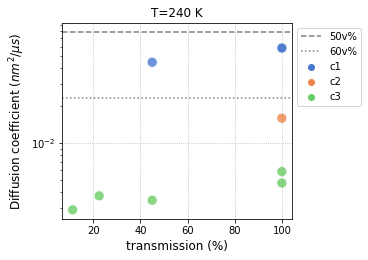

In [77]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5), constrained_layout=True)
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
data = df2[df2['temperature']==T_sel].sort_values(by='c')



ax.axhline(y=SE[SE['temperature']==T_sel]['D_50'].values[0], label='50v%', ls='--', c='gray')
ax.axhline(y=SE[SE['temperature']==T_sel]['D_60'].values[0], label='60v%', ls=':', c='gray')
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)

sns.scatterplot(data=data, x='transmission', y='D', hue='c', s=100,alpha=.8, ax=ax, palette="muted")
# D_concentrations = df2.sort_values(by='c')
ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('transmission (%)', fontsize=12)
ax.set_yscale('log')
ax.set_title(f'T={T_sel} K')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)